## 1. Inicialización

In [7]:
# Cargar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import levene, ttest_ind
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## 2. Carga los datos

In [8]:
# Cargar los datos
df_contract = pd.read_csv('contract.csv')
df_personal = pd.read_csv('personal.csv')
df_internet = pd.read_csv('internet.csv')
df_phone = pd.read_csv('phone.csv')

## 3. Análisis exploratorio y preprocesamiento de los datos

### Analizando el DF del contrato

In [ ]:
# Visualización de los primeros 10 registros
df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [ ]:
# Estructura de df_contract
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
# Renombrar columnas al formato snake_case
df_contract.columns = [ 'customer_id', 'begin_date', 'end_date', 'contract_type', 
               'paperless_billing', 'payment_method', 'monthly_charges', 
               'total_charges' ]

In [ ]:
# Checar si hay duplicados
df_contract.duplicated().sum()

np.int64(0)

In [ ]:
# Checar duplicados tramposos
df_contract[df_contract.duplicated(subset='customer_id', keep=False)].sort_values('customer_id')

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges


El DF tampoco tiene duplicados (lo mismo para toda la fila) ni duplicados tramposos (que se repitan en la columna customerID). Podemos continuar con el análisis.

In [14]:
# Creando la variable objetivo 
df_contract['churn'] = (df_contract['end_date'] != 'No').astype(int)

In [15]:
# Convirtiendo columnas segun su tipo
# Convertir fechas
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], errors='coerce')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], errors='coerce')  # Los 'No' se volverán NaT

# Convertir total_charges a float 
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')

# Convertir a categoría
categorical_cols = ['contract_type', 'paperless_billing', 'payment_method']
for col in categorical_cols:
    df_contract[col] = df_contract[col].astype('category')

# Convertir a float
df_contract['monthly_charges'] = df_contract['monthly_charges'].astype('float32')

C:\Users\elias\AppData\Local\Temp\ipykernel_30904\3549964567.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], errors='coerce')  # Los 'No' se volverán NaT


In [ ]:
# Checar estructura de df_contract
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   contract_type      7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float32       
 7   total_charges      7032 non-null   float64       
 8   churn              7043 non-null   int64         
dtypes: category(3), datetime64[ns](2), float32(1), float64(1), int64(1), object(1)
memory usage: 323.8+ KB


In [17]:
# Valores no numéricos de la columna total_charges
non_numeric = df_contract[pd.to_numeric(df_contract['total_charges'], errors='coerce').isna()]
print(non_numeric[['customer_id', 'monthly_charges','total_charges', 'churn']]) 

     customer_id  monthly_charges  total_charges  churn
488   4472-LVYGI        52.549999            NaN      0
753   3115-CZMZD        20.250000            NaN      0
936   5709-LVOEQ        80.849998            NaN      0
1082  4367-NUYAO        25.750000            NaN      0
1340  1371-DWPAZ        56.049999            NaN      0
3331  7644-OMVMY        19.850000            NaN      0
3826  3213-VVOLG        25.350000            NaN      0
4380  2520-SGTTA        20.000000            NaN      0
5218  2923-ARZLG        19.700001            NaN      0
6670  4075-WKNIU        73.349998            NaN      0
6754  2775-SEFEE        61.900002            NaN      0


In [ ]:
# Llenar NaN con los valores de monthly_charges
df_contract.loc[df_contract['total_charges'].isna(), 'total_charges'] = df_contract['monthly_charges']

Al verificar que todos los valores ausentes (NaN) en la columna total_charges tienen 0 en churn, podemos ver que se trata de clientes todavía activos. Con esto se puede deducir que, seguramente, son clientes que están en su primer mes con la compañía. Como tienen que pagarlo, decidí imputar el mismo valor de monthly_charges, es decir, les estoy cobrando ese mes. 

In [ ]:
# Checar estructura de df_contract
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   contract_type      7043 non-null   category      
 4   paperless_billing  7043 non-null   category      
 5   payment_method     7043 non-null   category      
 6   monthly_charges    7043 non-null   float32       
 7   total_charges      7043 non-null   float64       
 8   churn              7043 non-null   int64         
dtypes: category(3), datetime64[ns](2), float32(1), float64(1), int64(1), object(1)
memory usage: 323.8+ KB


In [ ]:
# Primeros 5 registros
df_contract.head(5)

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.850000,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.950001,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.849998,108.15,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.299999,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.699997,151.65,1


<Axes: title={'center': 'Distribución de tipos de contrato'}, xlabel='contract_type'>

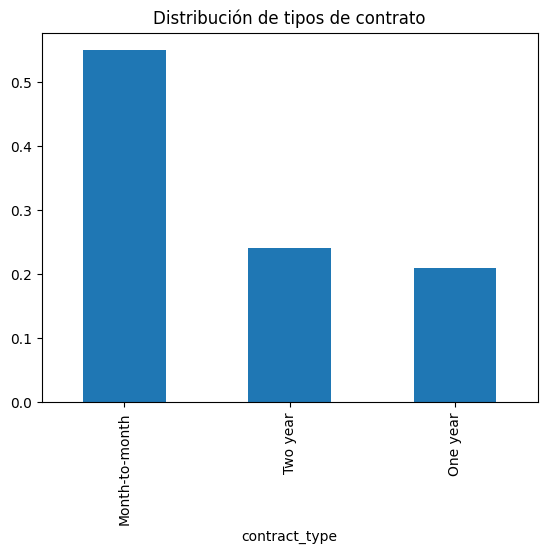

In [ ]:
# Distribución según el tipo de contrato
df_contract['contract_type'].value_counts(normalize=True).plot(kind='bar', title='Distribución de tipos de contrato')

<Axes: title={'center': 'Distribución de si el cliente recibe facturas de papel'}, xlabel='paperless_billing'>

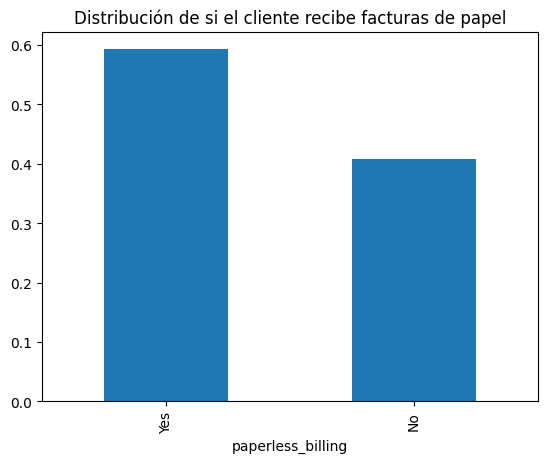

In [ ]:
# Distribución según la columna paperless_billing
df_contract['paperless_billing'].value_counts(normalize=True).plot(kind='bar', title='Distribución de si el cliente recibe facturas de papel')

<Axes: title={'center': 'Distribución de los metodos de pago'}, xlabel='payment_method'>

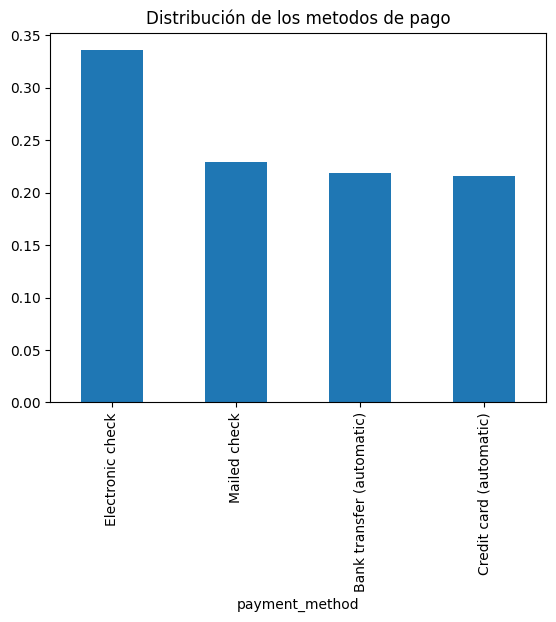

In [ ]:
# Distribución según los métodos de pago
df_contract['payment_method'].value_counts(normalize=True).plot(kind='bar', title='Distribución de los metodos de pago')

<Axes: title={'center': 'Distribución para saber si los clientes siguen activos'}, xlabel='churn'>

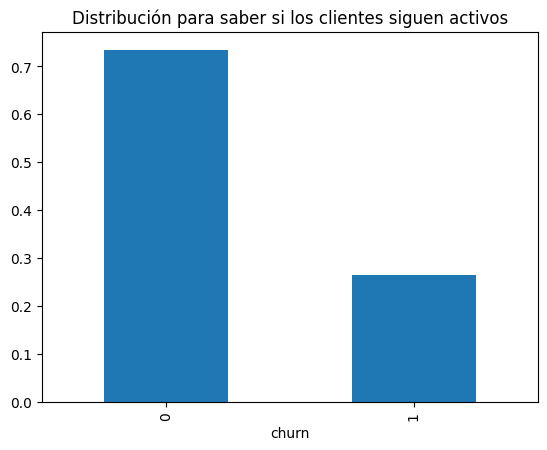

In [ ]:
# Distribución según el churn
df_contract['churn'].value_counts(normalize=True).plot(kind='bar', title='Distribución para saber si los clientes siguen activos')

Conclusiones:
- La columna contract_type establece que poco más del 50% de los datos pertenece a contratos mensuales, mientras que el resto corresponde 25% a contratos de un año y 25% a contratos de dos años, aproximadamente. Es muy probable que esta columna esté relacionada con la variable objetivo, eso se confirmará más adelante. 
- Los métodos automáticos como bank transfer y credit card sulen tener menor churn porque son más cómodos que los cheques, pero de igual manera, eso se confirmará más adelante. Los métodos representan un % muy parecido entre ellos. 
- El 60% sigue pidiendo facturas en papel. 
- El churn activo representa el 70% de los datos, mientras que el 30% canceló. La variable está un poco desbalanceada, lo que indica que usar AUC-ROC es una buena idea, pues no se ve tan afectada por el desbalance de clases como exactitud, por ejemplo. 

In [25]:
df_contract[['monthly_charges', 'total_charges']].describe()

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761696,2279.798992
std,30.090048,2266.730170
min,18.250000,18.800000
25%,35.500000,398.550000
50%,70.349998,1394.550000
75%,89.849998,3786.600000
max,118.750000,8684.800000


Se pueden deducir algunos puntos:
- La mediana (70.34) y la media (64.76) no presentan una diferencia tan significativa, lo que quiere decir que se trata de una distribución no tan asimétrica. 
- El cobro mínimo es de 18.25 y el máximo de 118.75 para monthly charges. Esto indica que varía mucho dependiendo de los servicios que los clientes hayan contratado.

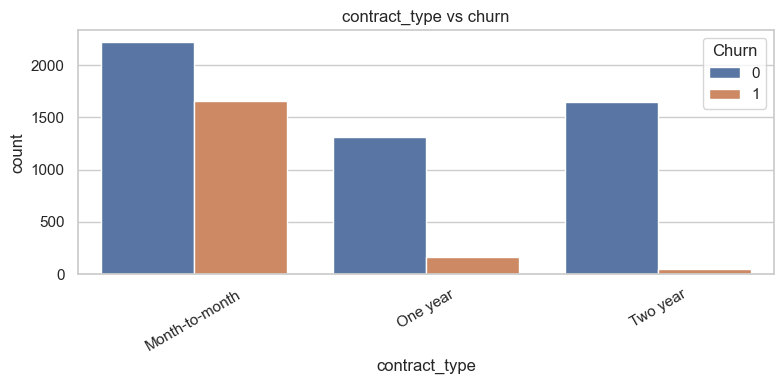

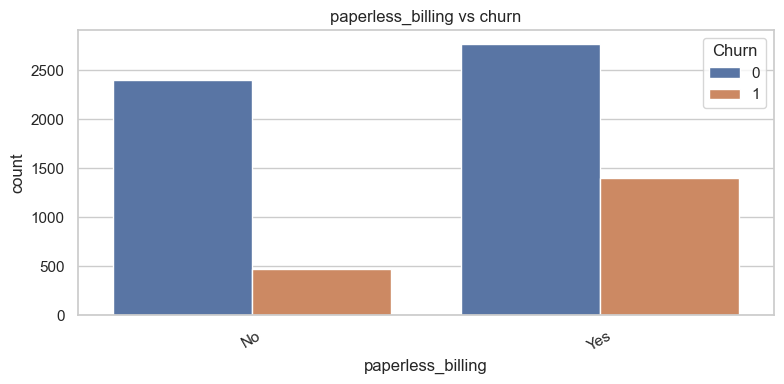

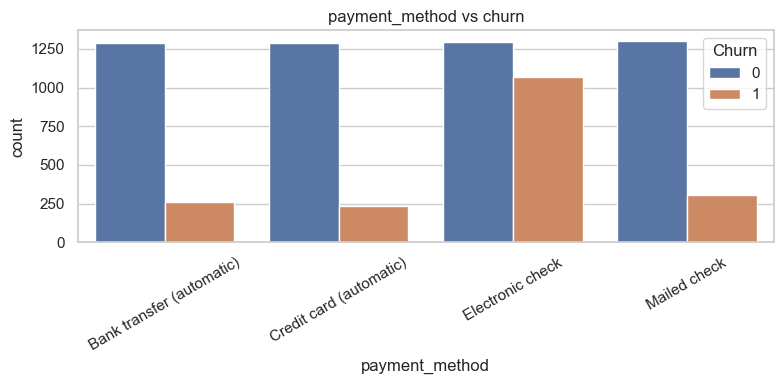

In [26]:
# Columnas categoricas y que tanto afectan a Churn
sns.set(style="whitegrid")
categorical_cols = ['contract_type', 'paperless_billing', 'payment_method']

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_contract, x=col, hue='churn')
    plt.title(f'{col} vs churn')
    plt.xticks(rotation=30)
    plt.legend(title='Churn')
    plt.tight_layout()
    plt.show()

In [ ]:
# Comprobación estadística de la asociación de columnas categóricas con churn
categorical_cols = ['contract_type', 'paperless_billing', 'payment_method']

for col in categorical_cols:
    contingency_table = pd.crosstab(df_contract[col], df_contract['churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\n{col.upper()}")
    print("p-valor:", p)
    if p < 0.05:
        print("→ Hay una asociación significativa con churn ✅")
    else:
        print("→ No hay evidencia suficiente de asociación con churn ❌")


CONTRACT_TYPE
p-valor: 5.863038300673391e-258
→ Hay una asociación significativa con churn ✅

PAPERLESS_BILLING
p-valor: 4.073354668665985e-58
→ Hay una asociación significativa con churn ✅

PAYMENT_METHOD
p-valor: 3.6823546520097993e-140
→ Hay una asociación significativa con churn ✅


Se puede observar que todas las variables categóricas afectan al objetivo. Por ejemplo, en el tipo de contrato, el de mes a mes tiene casi todos los casos de cancelación, tal y como se había previsto. Después, los usuarios que usan facturación sin papel, es decir, son digitales, tienen una mayor proporción de abandono. Se trata de clientes que, de bajo compromiso, es muy probable que estos clientes tengan contrato de mes a mes y por eso mismo no soliciten facturación con papel. Finalmente, observamos la importancia del método de pago, pues en cheque electrónico se encuentra la mayoría de usuarios que abandonaron, es importante recordar que este no es un método de pago automático. Todo esto fue comprobado de manera visual con las gráficas, sin embargo, con la prueba chi cuadrado podemos probar la dependencia de las variables respecto a churn de manera estadística.  

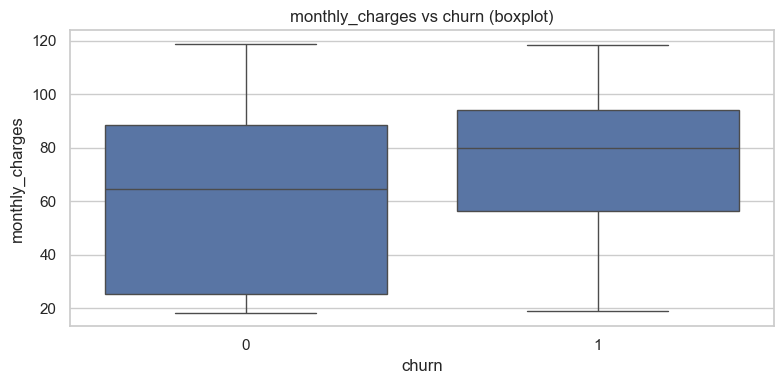

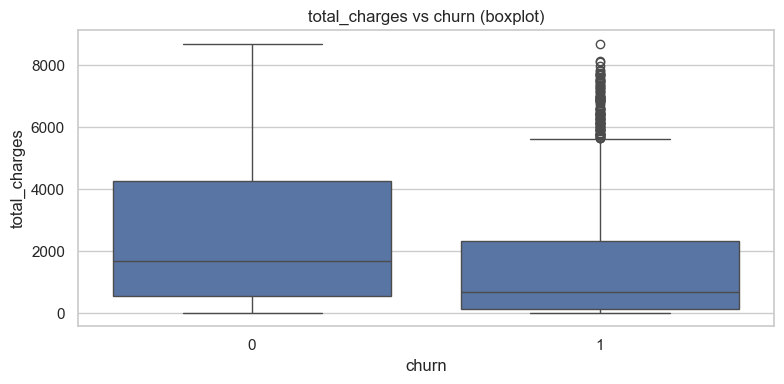

In [28]:
# Columnas numericas y que tanto afectan a Churn
numeric_cols = ['monthly_charges', 'total_charges']

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_contract, x='churn', y=col)
    plt.title(f'{col} vs churn (boxplot)')
    plt.xticks([0,1])
    plt.tight_layout()
    plt.show()

In [29]:
# Usar la fecha más reciente como fecha actual para los contratos activos
fecha_actual = max(df_contract['begin_date'].max(), df_contract['end_date'].max())

# Calcular la duración: si end_date es NaT, usar fecha_actual
df_contract['customer_duration_days'] = (df_contract['end_date'].fillna(fecha_actual) - df_contract['begin_date']).dt.days

# Convertir a meses 
df_contract['customer_duration_months'] = df_contract['customer_duration_days'] // 30

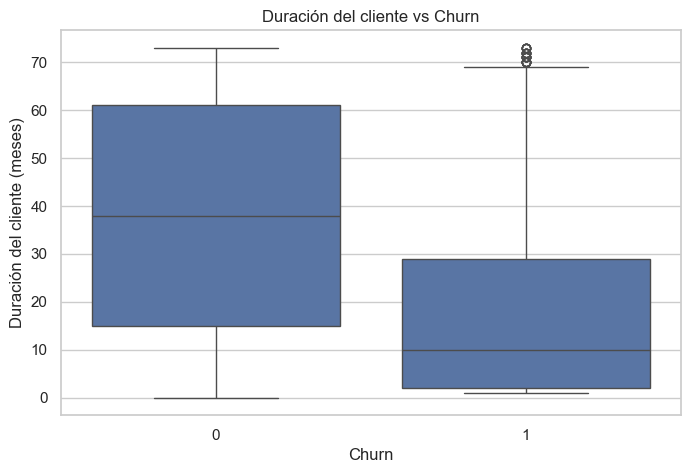

In [ ]:
# Boxplot 
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_contract, x='churn', y='customer_duration_months')
plt.title('Duración del cliente vs Churn')
plt.xlabel('Churn')
plt.ylabel('Duración del cliente (meses)')
plt.show()

Primero, es importante mencionar que se obtuvo una columna extra que es la de duración del contrato, para los NaT de end-date se utilizó la fecha máxima de este dataset, considerando begin_date y end_date. De esta forma no ponemos una fecha fuera del rango, por ejemplo, si pongo la fecha actual de 2025, alteraria los datos. La primera columna estaba en días y se convirtió a meses para que sea más práctico. 

In [ ]:
# Diferencia estadística entre subgrupos 
numeric_cols = ['monthly_charges', 'total_charges', 'customer_duration_months']

for col in numeric_cols:
    group_0 = df_contract[df_contract['churn'] == 0][col].dropna()
    group_1 = df_contract[df_contract['churn'] == 1][col].dropna()
    
    # Prueba de igualdad de varianzas
    stat_levene, p_levene = levene(group_0, group_1)
    equal_var = p_levene > 0.05  # Si p > 0.05, asumimos varianzas iguales

    # Prueba t de Student (con o sin igualdad de varianzas)
    t_stat, p_ttest = ttest_ind(group_0, group_1, equal_var=equal_var)

    print(f"\n{col.upper()}")
    print(f"Prueba de Levene p-valor: {p_levene:.4f} → {'Varianzas iguales' if equal_var else 'Varianzas distintas'}")
    print(f"t-test p-valor: {p_ttest:.4f}")
    if p_ttest < 0.05:
        print("→ Hay una diferencia significativa con respecto a churn ✅")
    else:
        print("→ No se encontró diferencia significativa con respecto a churn ❌") 


MONTHLY_CHARGES
Prueba de Levene p-valor: 0.0000 → Varianzas distintas
t-test p-valor: 0.0000
→ Hay una diferencia significativa con respecto a churn ✅

TOTAL_CHARGES
Prueba de Levene p-valor: 0.0000 → Varianzas distintas
t-test p-valor: 0.0000
→ Hay una diferencia significativa con respecto a churn ✅

CUSTOMER_DURATION_MONTHS
Prueba de Levene p-valor: 0.0000 → Varianzas distintas
t-test p-valor: 0.0000
→ Hay una diferencia significativa con respecto a churn ✅


En todos los casos (monthly_charges, total_charges, customer_duration_months), se encontró evidencia estadística de que las medias difieren significativamente entre clientes que cancelaron (churn = 1) y los que permanecieron (churn = 0). Esto sugiere que estas variables pueden estar asociadas con la decisión de cancelar y deben considerarse como candidatas para el modelo predictivo.

In [ ]:
# Estructura de df_contract
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_id               7043 non-null   object        
 1   begin_date                7043 non-null   datetime64[ns]
 2   end_date                  1869 non-null   datetime64[ns]
 3   contract_type             7043 non-null   category      
 4   paperless_billing         7043 non-null   category      
 5   payment_method            7043 non-null   category      
 6   monthly_charges           7043 non-null   float32       
 7   total_charges             7043 non-null   float64       
 8   churn                     7043 non-null   int64         
 9   customer_duration_days    7043 non-null   int64         
 10  customer_duration_months  7043 non-null   int64         
dtypes: category(3), datetime64[ns](2), float32(1), float64(1), int64(3), object(1)
mem

In [ ]:
# Primeros 5 registros
df_contract.head(5)

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_duration_days,customer_duration_months
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.850000,29.85,0,31,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.950001,1889.50,0,1036,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.849998,108.15,1,61,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.299999,1840.75,0,1371,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.699997,151.65,1,61,2


Ya para concluir, las columnas relevantes para el modelo predictivo de este DF son: contract_type, paperless_billing, payment_method, monthly_charges, total_charges y customer_duration_months. 

### Analizando el DF de los datos personales del cliente

In [ ]:
# Estructura de df_personal
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
# Primeros 10 registros
df_personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


El DF no tiene valores ausentes (NaN), por lo que se puede continuar convirtiendo las columnas al formato snake_case.

In [ ]:
# Renombrar columnas
df_personal.columns = [ 'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents' ]

In [ ]:
# Checar duplicados
df_personal.duplicated().sum()

np.int64(0)

In [ ]:
# Checar duplicados tramposos (customer_id)
df_personal[df_personal.duplicated(subset='customer_id', keep=False)].sort_values('customer_id')

,customer_id,gender,senior_citizen,partner,dependents


El DF tampoco tiene duplicados (lo mismo para toda la fila) ni duplicados tramposos (que se repitan en la columna customerID). Podemos continuar con el análisis.

In [ ]:
# Convertir columnas al formato adecaudo
df_personal['gender'] = df_personal['gender'].astype('category')
df_personal['partner'] = df_personal['partner'].astype('category')
df_personal['dependents'] = df_personal['dependents'].astype('category')
df_personal['senior_citizen'] = df_personal['senior_citizen'].astype('category')

In [ ]:
# Estructura de df_personal
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     7043 non-null   object  
 1   gender          7043 non-null   category
 2   senior_citizen  7043 non-null   category
 3   partner         7043 non-null   category
 4   dependents      7043 non-null   category
dtypes: category(4), object(1)
memory usage: 83.1+ KB


<Axes: title={'center': 'Distribución del genero de los clientes'}, xlabel='gender'>

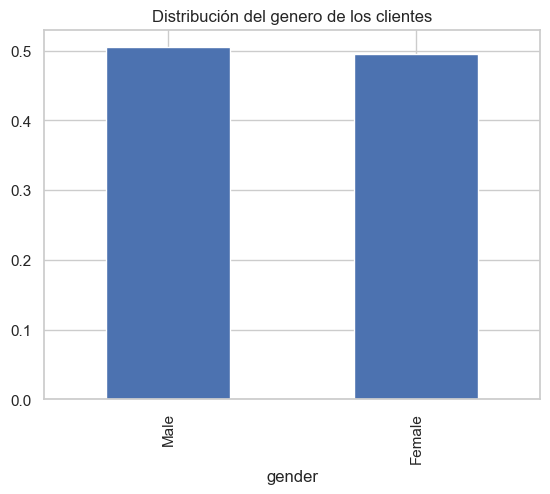

In [41]:
df_personal['gender'].value_counts(normalize=True).plot(kind='bar', title='Distribución del genero de los clientes')

<Axes: title={'center': 'Distribución de la vejez de los clientes'}, xlabel='senior_citizen'>

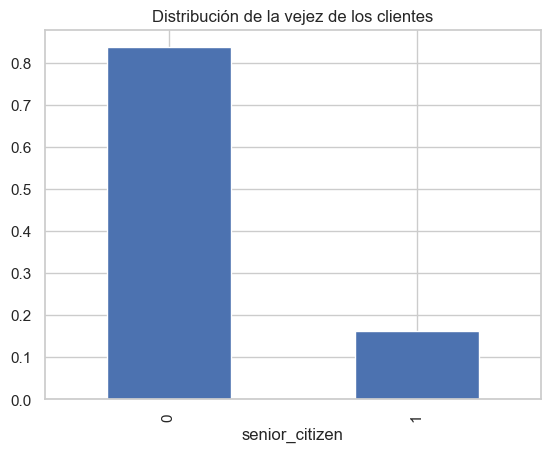

In [42]:
df_personal['senior_citizen'].value_counts(normalize=True).plot(kind='bar', title='Distribución de la vejez de los clientes')

<Axes: title={'center': 'Distribución del estado sentimental de los clientes'}, xlabel='partner'>

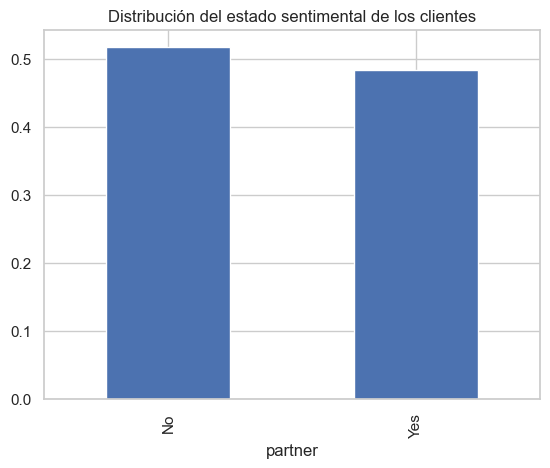

In [43]:
df_personal['partner'].value_counts(normalize=True).plot(kind='bar', title='Distribución del estado sentimental de los clientes')

<Axes: title={'center': 'Dependientes de los clientes'}, xlabel='dependents'>

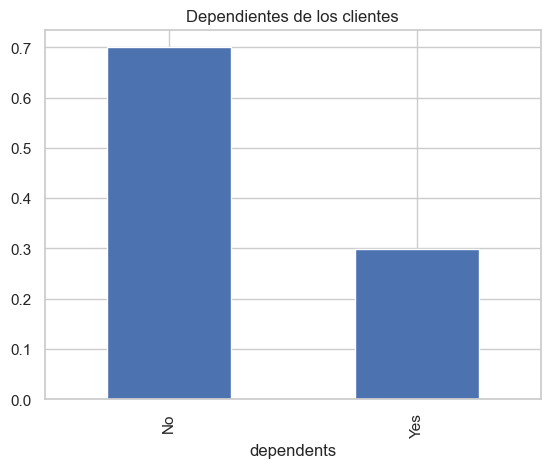

In [44]:
df_personal['dependents'].value_counts(normalize=True).plot(kind='bar', title='Dependientes de los clientes')

Conclusiones:
- La distribución del género es prácticamente igual, la masculina es ligeramente superior, pero casi al 50%.
- Menos del 20% de los clientes están en la etapa de la vejez. 
- Un poco más del 50% de los clientes tienen pareja.
- Aproximadamente el 70% de los clientes no tienen dependientes, seguramente se trata entonces de clientes en su mayoría jóvenes, lo cual confirma la información de la vejez. 

In [45]:
# Verificamos unicidad
assert df_personal['customer_id'].is_unique
assert df_contract['customer_id'].is_unique

In [ ]:
# Merge entre df_personal y df_contract
df_demo = df_personal.merge(df_contract[['customer_id', 'churn']], on='customer_id', how='left')

In [47]:
df_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     7043 non-null   object  
 1   gender          7043 non-null   category
 2   senior_citizen  7043 non-null   category
 3   partner         7043 non-null   category
 4   dependents      7043 non-null   category
 5   churn           7043 non-null   int64   
dtypes: category(4), int64(1), object(1)
memory usage: 138.2+ KB


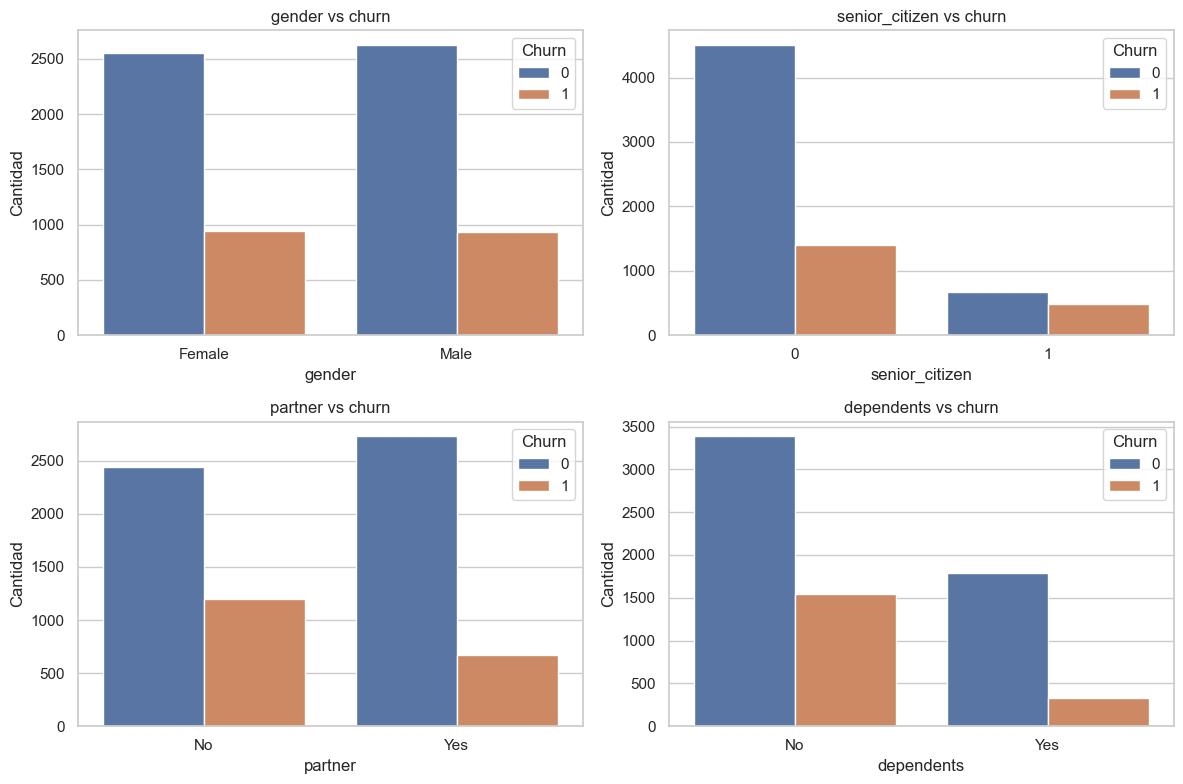

In [ ]:
# Graficar relación entre variables categóricas y churn
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(['gender', 'senior_citizen', 'partner', 'dependents']):
    sns.countplot(data=df_demo, x=col, hue='churn', ax=axes[i])
    axes[i].set_title(f'{col} vs churn')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Cantidad')
    axes[i].legend(title='Churn')

plt.tight_layout()
plt.show()

In [49]:
# Lista de columnas categóricas a evaluar
cat_cols_personal = ['gender', 'senior_citizen', 'partner', 'dependents']

# Iterar sobre cada columna y aplicar chi-cuadrado
for col in cat_cols_personal:
    contingency_table = pd.crosstab(df_demo[col], df_demo['churn'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f'\n{col.upper()}')
    print('Tabla de contingencia:')
    print(contingency_table)
    print(f'\np-valor: {p:.4f}')
    
    if p < 0.05:
        print('→ Existe una asociación significativa con churn ✅')
    else:
        print('→ No se encontró una asociación significativa con churn ❌')


GENDER
Tabla de contingencia:
churn      0    1
gender           
Female  2549  939
Male    2625  930

p-valor: 0.4866
→ No se encontró una asociación significativa con churn ❌

SENIOR_CITIZEN
Tabla de contingencia:
churn              0     1
senior_citizen            
0               4508  1393
1                666   476

p-valor: 0.0000
→ Existe una asociación significativa con churn ✅

PARTNER
Tabla de contingencia:
churn       0     1
partner            
No       2441  1200
Yes      2733   669

p-valor: 0.0000
→ Existe una asociación significativa con churn ✅

DEPENDENTS
Tabla de contingencia:
churn          0     1
dependents            
No          3390  1543
Yes         1784   326

p-valor: 0.0000
→ Existe una asociación significativa con churn ✅


Conclusiones:
- Género: La distribución del género es prácticamente igual, la masculina es ligeramente superior, pero casi al 50%. Y eso se demuestra estadísticamente, pues el género no es lo suficientemente importante respecto a churn. 
- Vejez: Menos del 20% de los clientes están en la etapa de la vejez. Esta variable tiene una asociación significativa con churn. 
- Pareja: Un poco más del 50% de los clientes tienen pareja. Esta variable también tiene una asociación significativa con churn. 
- Dependientes: Aproximadamente el 70% de los clientes no tienen dependientes, seguramente se trata entonces de clientes en su mayoría jóvenes, lo cual confirma la información de la vejez. Esta variable tiene una asociación significativa con churn. 

### Analizando el DF sobre servicios de internet

In [50]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Lo primero que me llama la atención es ver que este DF no tiene la misma cantidad de registros que los otros. Esto quiere decir, seguramente, que no todos los clientes tienen internet contratado, por lo que esto puede provocar valores ausentes en el futuro. El DF no tiene NaN, por lo que podemos continuar con el análisis.

In [51]:
df_internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [52]:
df_internet.duplicated().sum()

np.int64(0)

In [ ]:
# Renombrar columnas
df_internet.columns = ['customer_id', 'internet_service', 'online_security', 'online_backup',
 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

In [54]:
# Convertir columnas a tipo categoría
cat_columns = df_internet.columns.drop('customer_id')  # todas menos el ID
df_internet[cat_columns] = df_internet[cat_columns].astype('category')

In [55]:
df_internet[df_internet.duplicated(subset='customer_id', keep=False)].sort_values('customer_id')

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies


El DF tampoco tiene duplicados (lo mismo para toda la fila) ni duplicados tramposos (que se repitan en la columna customerID). Podemos continuar con el análisis.

In [56]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   customer_id        5517 non-null   object  
 1   internet_service   5517 non-null   category
 2   online_security    5517 non-null   category
 3   online_backup      5517 non-null   category
 4   device_protection  5517 non-null   category
 5   tech_support       5517 non-null   category
 6   streaming_tv       5517 non-null   category
 7   streaming_movies   5517 non-null   category
dtypes: category(7), object(1)
memory usage: 81.8+ KB


In [57]:
# Crear copia de df_internet para mantenerlo limpio
df_internet_churn = df_internet.copy()

# Unir con df_contract para traer la columna churn
df_internet_churn = df_internet_churn.merge(df_contract[['customer_id', 'monthly_charges','churn']], on='customer_id', how='left')

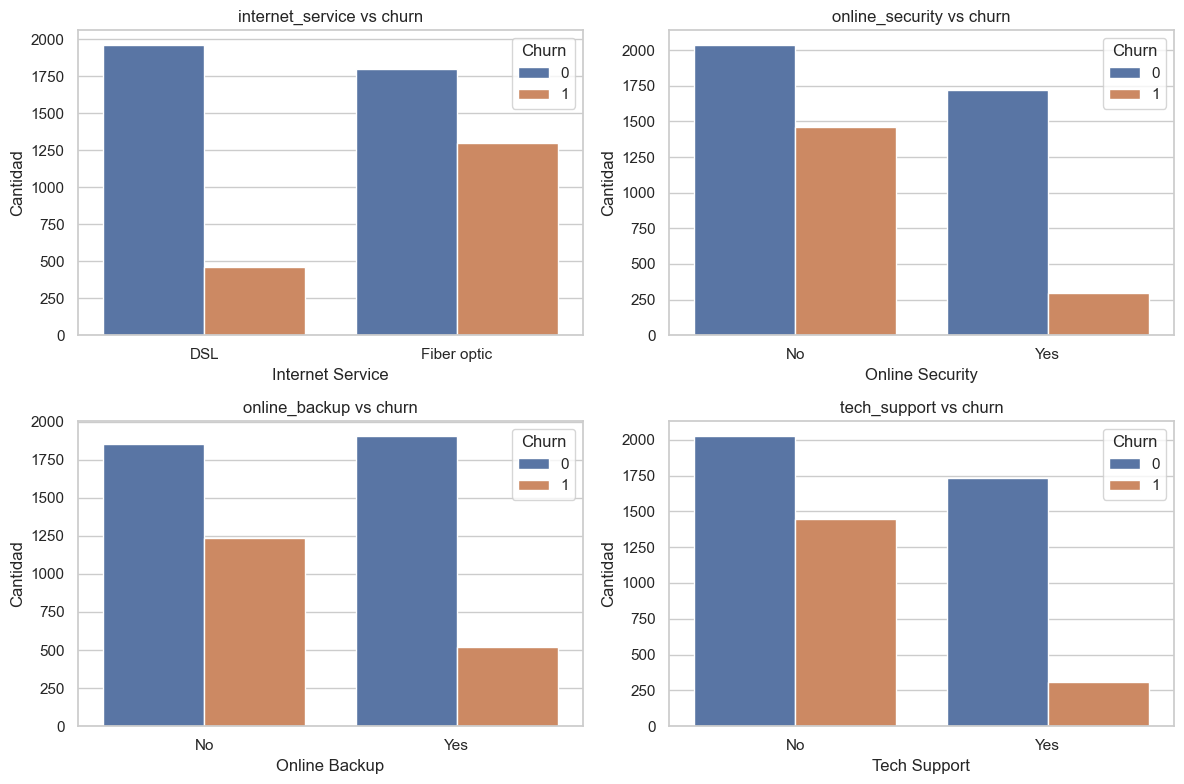

In [58]:
# Lista de columnas a comparar
cols_to_plot = ['internet_service', 'online_security', 'online_backup', 'tech_support']

# Crear subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Crear gráfico por cada columna
for i, col in enumerate(cols_to_plot):
    sns.countplot(data=df_internet_churn, x=col, hue='churn', ax=axes[i])
    axes[i].set_title(f'{col} vs churn')
    axes[i].set_xlabel(col.replace('_', ' ').title())  
    axes[i].set_ylabel('Cantidad')
    axes[i].legend(title='Churn')

plt.tight_layout()
plt.show()

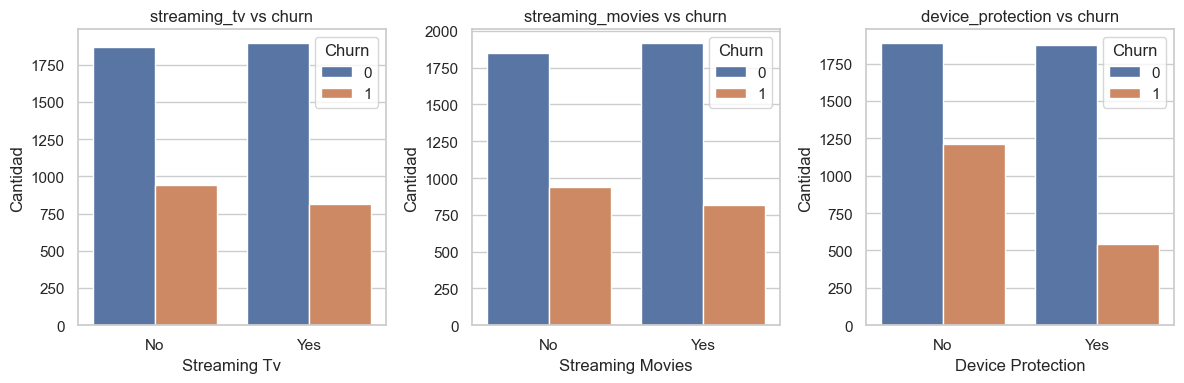

In [59]:
# Lista de columnas a comparar
cols_to_plot_2 = ['streaming_tv', 'streaming_movies','device_protection']

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

# Crear gráfico por cada columna
for i, col in enumerate(cols_to_plot_2):
    sns.countplot(data=df_internet_churn, x=col, hue='churn', ax=axes[i])
    axes[i].set_title(f'{col} vs churn')
    axes[i].set_xlabel(col.replace('_', ' ').title())  
    axes[i].set_ylabel('Cantidad')
    axes[i].legend(title='Churn')

plt.tight_layout()
plt.show()


In [60]:
# Lista de columnas categóricas del df_internet
cat_columns = [
    'internet_service',
    'online_security',
    'online_backup',
    'device_protection',
    'tech_support',
    'streaming_tv',
    'streaming_movies'
]

# Ejecutar la prueba chi-cuadrado para cada columna
for col in cat_columns:
    tabla = pd.crosstab(df_internet_churn[col], df_internet_churn['churn'])
    chi2, p, dof, expected = chi2_contingency(tabla)
    print(f"{col.upper()}")
    print("Tabla de contingencia:")
    print(tabla)
    print(f"p-valor: {p:.4f}")
    if p < 0.05:
        print("→ Existe una asociación significativa con churn ✅\n")
    else:
        print("→ No se encontró una asociación significativa con churn ❌\n")

INTERNET_SERVICE
Tabla de contingencia:
churn                0     1
internet_service            
DSL               1962   459
Fiber optic       1799  1297
p-valor: 0.0000
→ Existe una asociación significativa con churn ✅

ONLINE_SECURITY
Tabla de contingencia:
churn               0     1
online_security            
No               2037  1461
Yes              1724   295
p-valor: 0.0000
→ Existe una asociación significativa con churn ✅

ONLINE_BACKUP
Tabla de contingencia:
churn             0     1
online_backup            
No             1855  1233
Yes            1906   523
p-valor: 0.0000
→ Existe una asociación significativa con churn ✅

DEVICE_PROTECTION
Tabla de contingencia:
churn                 0     1
device_protection            
No                 1884  1211
Yes                1877   545
p-valor: 0.0000
→ Existe una asociación significativa con churn ✅

TECH_SUPPORT
Tabla de contingencia:
churn            0     1
tech_support            
No            2027  1446
Yes         

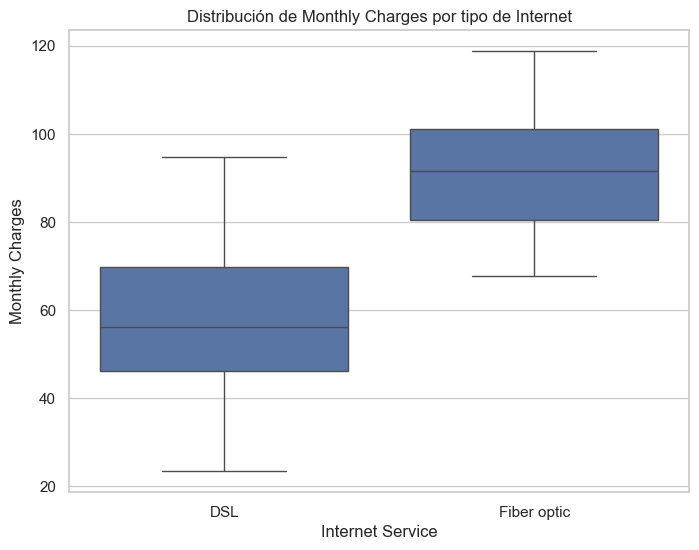

In [61]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_internet_churn, x='internet_service', y='monthly_charges')
plt.title('Distribución de Monthly Charges por tipo de Internet')
plt.xlabel('Internet Service')
plt.ylabel('Monthly Charges')
plt.show()

Se realizó una prueba de chi-cuadrado de independencia para evaluar si existe una relación significativa entre la tasa de abandono del servicio (churn) y todas las variables la tienen, pues el p-value de todas es menor a 0.05. Se trata de las siguientes:

- internet_service
- online_security
- online_backup
- device_protection
- tech_support
- streaming_tv
- streaming_movies

En particular, destaca la variable internet_service, donde los usuarios con servicio de fibra óptica muestran una tasa de abandono mucho mayor en comparación con los usuarios de DSL. Este resultado coincide con los gráficos exploratorios realizados previamente, donde se observa que los clientes con fibra óptica tienen, en promedio, costos mensuales más elevados, lo cual podría ser un factor importante en su decisión de cancelar el servicio.

### Analizando el DF sobre los servicios telefónicos

In [62]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [63]:
df_phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [64]:
df_phone.columns = ['customer_id','multiple_lines']

In [65]:
df_phone['multiple_lines'] = df_phone['multiple_lines'].astype('category')

In [66]:
df_phone.duplicated().sum()

np.int64(0)

In [67]:
df_phone[df_phone.duplicated(subset='customer_id', keep=False)].sort_values('customer_id')

,customer_id,multiple_lines


El DF no tiene valores ausentes, duplicados (lo mismo para toda la fila) ni duplicados tramposos (que se repitan en la columna customer_id). Podemos continuar con el análisis. Es importante mencionar que el DF tiene menos registros que los primeros dos, lo que indica que no todos los clientes tienen teléfono, esto puede generar NaN al momento de unir DF previo a entrenar diferentes modelos. La columna multiple lines se refiere a si el cliente tiene varias líneas telefónicas (yes) o una (no). 

<Axes: title={'center': 'Multiple Lines'}, xlabel='multiple_lines'>

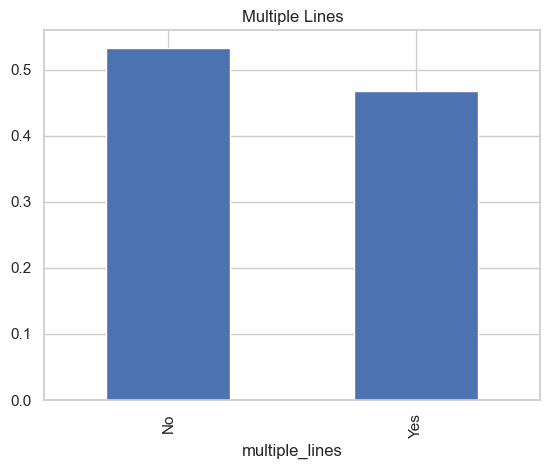

In [68]:
df_phone['multiple_lines'].value_counts(normalize=True).plot(kind='bar', title='Multiple Lines')

In [69]:
# Unir churn al df_phone
df_phone_churn = df_phone.merge(
    df_contract[['customer_id', 'churn']],
    on='customer_id',
    how='left')

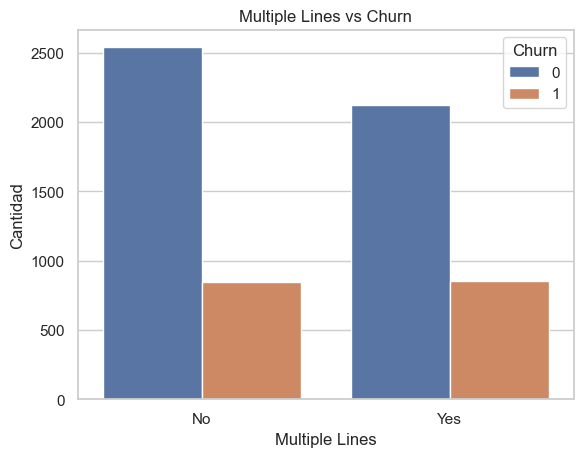

In [70]:
sns.countplot(data=df_phone_churn, x='multiple_lines', hue='churn')
plt.title('Multiple Lines vs Churn')
plt.xlabel('Multiple Lines')
plt.ylabel('Cantidad')
plt.legend(title='Churn')
plt.show()

In [71]:
df_phone_churn = df_phone.merge(
    df_contract[['customer_id', 'churn']],
    on='customer_id',
    how='left')

In [72]:
# Crear tabla de contingencia
contingency_table = pd.crosstab(df_phone_churn['multiple_lines'], df_phone_churn['churn'])

# Aplicar prueba chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Mostrar resultados
print("Tabla de contingencia:")
print(contingency_table)
print(f"\nValor p: {p:.4f}")
if p < 0.05:
    print("→ Existe una asociación significativa con churn ✅")
else:
    print("→ No se encontró una asociación significativa con churn ❌")

Tabla de contingencia:
churn              0    1
multiple_lines           
No              2541  849
Yes             2121  850

Valor p: 0.0015
→ Existe una asociación significativa con churn ✅


La proporción de personas que sí tienen múltiples líneas tienen una proporción de abandono mayor. Estadísticamente es suficiente para concluir que existe una asociación significativa con churn. 

## 4. Unificación y preparacion de los DF: combinar los DF obteniendo un consolidado de características. 

In [73]:
# Empezamos con los dos DF más grandes: df_contract y df_personal
df_merged = df_contract.merge(df_personal, on='customer_id', how='left')

# Añadimos df_internet
df_merged = df_merged.merge(df_internet, on='customer_id', how='left')

# Finalmente, añadimos df_phone
df_merged = df_merged.merge(df_phone, on='customer_id', how='left')

In [74]:
df_merged.drop(['begin_date', 'end_date', 'customer_duration_days'], axis=1, inplace=True)

In [75]:
# Columnas de internet
internet_cols = ['internet_service', 'online_security', 'online_backup', 
                 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

# Agregar la categoría 'No internet' a cada una de estas columnas
for col in internet_cols:
    df_merged[col] = df_merged[col].cat.add_categories('No internet')

# Imputar los NaN con 'No internet'
df_merged[internet_cols] = df_merged[internet_cols].fillna('No internet')

# Lo mismo con la columna de phone
df_merged['multiple_lines'] = df_merged['multiple_lines'].cat.add_categories('No phone')
df_merged['multiple_lines'] = df_merged['multiple_lines'].fillna('No phone')

In [76]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   customer_id               7043 non-null   object  
 1   contract_type             7043 non-null   category
 2   paperless_billing         7043 non-null   category
 3   payment_method            7043 non-null   category
 4   monthly_charges           7043 non-null   float32 
 5   total_charges             7043 non-null   float64 
 6   churn                     7043 non-null   int64   
 7   customer_duration_months  7043 non-null   int64   
 8   gender                    7043 non-null   category
 9   senior_citizen            7043 non-null   category
 10  partner                   7043 non-null   category
 11  dependents                7043 non-null   category
 12  internet_service          7043 non-null   category
 13  online_security           7043 non-null   catego

In [77]:
df_merged.sample(10)

,customer_id,contract_type,paperless_billing,payment_method,monthly_charges,total_charges,churn,customer_duration_months,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
1126,0927-LCSMG,Month-to-month,No,Mailed check,74.650002,544.55,1,7,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
5149,3970-XGJDU,Two year,Yes,Credit card (automatic),19.200001,1123.65,0,62,Female,0,No,No,No internet,No internet,No internet,No internet,No internet,No internet,No internet,No
5466,0221-NAUXK,One year,Yes,Bank transfer (automatic),19.950001,219.50,0,10,Male,0,No,Yes,No internet,No internet,No internet,No internet,No internet,No internet,No internet,No
860,4795-UXVCJ,One year,No,Credit card (automatic),19.799999,457.30,0,26,Male,0,No,No,No internet,No internet,No internet,No internet,No internet,No internet,No internet,No
1185,5673-FSSMF,Month-to-month,Yes,Electronic check,60.150002,60.15,1,1,Female,0,No,No,DSL,No,No,No,No,No,Yes,Yes
5851,4118-CEVPF,One year,Yes,Bank transfer (automatic),110.800003,3836.30,0,35,Female,1,No,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3737,8601-QACRS,Month-to-month,Yes,Mailed check,50.599998,249.95,1,5,Female,0,No,No,DSL,No,No,No,No,No,No,Yes
3829,8374-XGEJJ,Month-to-month,Yes,Electronic check,101.000000,4388.40,1,43,Male,1,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,Yes
6315,5696-JVVQY,Two year,Yes,Credit card (automatic),70.099998,3238.40,0,48,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,No,Yes,No
2927,5542-TBBWB,Month-to-month,Yes,Electronic check,69.900002,69.90,0,1,Male,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [78]:
print(df_merged[(df_merged['online_security'] == 'No internet') & 
                (df_merged['multiple_lines'] == 'No phone')])

Empty DataFrame
Columns: [customer_id, contract_type, paperless_billing, payment_method, monthly_charges, total_charges, churn, customer_duration_months, gender, senior_citizen, partner, dependents, internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, multiple_lines]
Index: []


Se confirmó que los usuarios tienen al menos uno de los dos servicios (internet o teléfono) contratado en ese momento o incluso ya cancelado. 

In [79]:
# Separar 
X = df_merged.drop(columns=['customer_id', 'churn'])
y = df_merged['churn']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Detectar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Preprocesamiento por tipo de variable
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Transformación a train y test
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

## 5. Evaluación de los modelos 

In [80]:
# Definir modelos
log_reg = LogisticRegression(random_state=42, max_iter=1000)
random_forest = RandomForestClassifier(random_state=42)
light_gbm = LGBMClassifier(random_state=42)

In [81]:
# Definir grids de hiperparámetros
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_lgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, -1],
    'learning_rate': [0.01, 0.1, 0.3]
}

In [82]:
# Aplicar GridSearchCV
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf = GridSearchCV(random_forest, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lgb = GridSearchCV(light_gbm, param_grid_lgb, cv=5, scoring='roc_auc', n_jobs=-1)

In [83]:
# Entrenar modelos
grid_lr.fit(X_train_prepared, y_train)
grid_rf.fit(X_train_prepared, y_train)
grid_lgb.fit(X_train_prepared, y_train)

[LightGBM] [Info] Number of positive: 1390, number of negative: 3892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 412
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.263158 -> initscore=-1.029619
[LightGBM] [Info] Start training from score -1.029619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,estimator,LGBMClassifie...ndom_state=42)
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [3, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [84]:
# Comparar resultados del entrenamiento
print(f"Mejor AUC-ROC Logistic Regression: {grid_lr.best_score_:.4f}")
print(f"Mejor AUC-ROC Random Forest: {grid_rf.best_score_:.4f}")
print(f"Mejor AUC-ROC LightGBM: {grid_lgb.best_score_:.4f}")

print(f"Mejores parametros Logistic Regression: {grid_lr.best_params_}")
print(f"Mejores parametros Random Forest: {grid_rf.best_params_}")
print(f"Mejores Parametros LightLGB: {grid_lgb.best_params_}")

Mejor AUC-ROC Logistic Regression: 0.8408
Mejor AUC-ROC Random Forest: 0.8413
Mejor AUC-ROC LightGBM: 0.8462
Mejores parametros Logistic Regression: {'C': 100, 'solver': 'liblinear'}
Mejores parametros Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Mejores Parametros LightLGB: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [85]:
# Obtener los mejores modelos
best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_
best_lgb = grid_lgb.best_estimator_

# Predicciones
y_pred_lr = best_lr.predict(X_test_prepared)
y_pred_rf = best_rf.predict(X_test_prepared)
y_pred_lgb = best_lgb.predict(X_test_prepared)

# Probabilidad
y_proba_lr = best_lr.predict_proba(X_test_prepared)[:, 1]
y_proba_rf = best_rf.predict_proba(X_test_prepared)[:, 1]
y_proba_lgb = best_lgb.predict_proba(X_test_prepared)[:, 1]

c:\Users\elias\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\elias\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [86]:
# Funcion para evaluar
def evaluar_modelo(y_test, y_pred, y_proba, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n {model_name} Performance")
    print(f"AUC-ROC:  {auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

In [87]:
# Evaluar cada modelo
evaluar_modelo(y_test, y_pred_lr, y_proba_lr,"Logistic regression")
evaluar_modelo(y_test, y_pred_rf, y_proba_rf,"Random Forest")
evaluar_modelo(y_test, y_pred_lgb, y_proba_lgb,"Light LGB")


 Logistic regression Performance
AUC-ROC:  0.8606
Accuracy: 0.8137

 Random Forest Performance
AUC-ROC:  0.8564
Accuracy: 0.7961

 Light LGB Performance
AUC-ROC:  0.8586
Accuracy: 0.8018


Los tres modelos obtuvieron un AUC-ROC muy bueno, alcanzando las expectativas para obtener los 5 SP establecidos. Específicamente, el AUC-ROC de Logistic Regression fue de 0.8606, alcanzando los 5P. Esto sugiere que la relación entre las variables predictoras y el churn tienen una asociación lineal, ofreciendo el mejor desempeño y capacidad de generalización. Llama la atención que el AUC-ROC mejoró en el test todavía más de lo que era en el train. 